# Advanced Machine Learning: Assignment 2

Nome e cognome: Confalonieri Riccardo <br>
Matricola: 830404<br>
E-mail: r.confalonieri5@campus.unimib.it

# Prediction of grayscale images of letters P - Z.
<p align='justify'>
The assignment consists on the prediction of grayscale images of letters P - Z of handwritten letter dataset with a visual investigation of the reconstruction abilities of an auto-encoder architecture.

The Dataset consists of 14000 training labelled images and 8800 test images.
</p>

## Import packages

In [ ]:
# for mounting GDrive
from google.colab import drive

# read dataset
import pickle

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import random 

# for splitting dataset
from sklearn.model_selection import train_test_split

# for preprocessing
import numpy as np 

# for neural network
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
# importing keras layers for the model (dropout per regularization)
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Input
# for autoencoder
from keras.models import Model
# for model optimizer
from tensorflow.keras.optimizers import SGD
# regularization
from keras.callbacks import EarlyStopping
from keras import regularizers
# for model plot
from keras.utils.vis_utils import plot_model

# For evaluate classification 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

## Loading data
<p align='justify'>
In questa sezione carico i dataset contenenti tutti i dati necessari. Per il caricamento mi avvalgo del collegamento a Google Drive per evitare di importare i singoli file in un path locale.
</p>

In [ ]:
# mount personal gdrive folder
drive.mount('/content/drive')

# define data folder path
drive_path = '/content/drive/MyDrive/Colab Notebooks/AML/Assignment/Assignment2/Dati/'

Mounted at /content/drive


In [ ]:
# loading train (x and y variables) and test set (only x variables)
x_train = pickle.load(open(drive_path + "x_train.obj","rb"))

x_test = pickle.load(open(drive_path + "x_test.obj","rb"))

y_train = pickle.load(open(drive_path + "y_train.obj","rb"))

## Inspecting the data
<p align='justify'>
In questa sezione analizzero i dataset appena caricati, dato che sono immagini provo anche a visualizzarne qualcuna per capire meglio la composizione del dataset.
</p>

### General analysis

In [ ]:
# check basic info
print('Tipo delle immagini:', type(x_train))
print('Numero di esempi di training:', x_train.shape[0])
print('Numero di label per il training:', y_train.shape[0])
print("Dimensione dell'immagine: " + str(x_train.shape[1]) + "x" + str(x_train.shape[2]))
print("Range di valori dell'immagine ["+ str(x_train.min()) + "," 
      + str(x_train.max()) + "]")
print("Tipo dei valori dell'immagine: ", type(x_train[0,10,12]))
print('Numero di esempi di test:', x_test.shape[0])


Tipo delle immagini: <class 'numpy.ndarray'>
Numero di esempi di training: 14000
Numero di label per il training: 14000
Dimensione dell'immagine: 28x28
Range di valori dell'immagine [0,255]
Tipo dei valori dell'immagine:  <class 'numpy.uint8'>
Numero di esempi di test: 8800


<p align='justify'>
Il dataset caricato di contiene 14000 esempi di immagini, ogni immagine ha una grandezza 28x28 che però è riportata in due dimensioni diverse. 
Inoltre i valori sono nel range $[0, 255]$ e sono di tipo intero, per i modelli neurali occorrerà quindi <i>gestire sia la dimensione dell'array sia convertire i valori in float</i> con range $[0, 1]$. <br>
Visualizzo quindi tutte le possibili classe di appartenenza presenti nel dataset. <br>
</p>


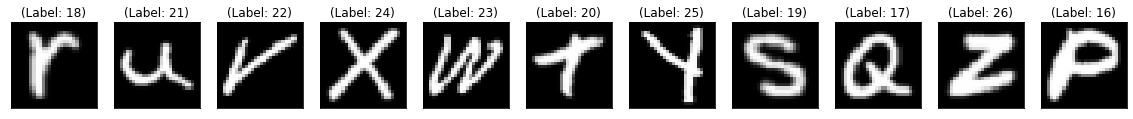

In [ ]:
plt.figure(figsize=(20, 4))
lst_label_visualized = []
i = 0
while i < 11:
  idx = random.randint(0, len(y_train))
  # check if I have already display this label
  if y_train[idx] not in lst_label_visualized:
    ax = plt.subplot(2, 11, i + 1)
    # colormap = gray for better visualization
    plt.imshow(x_train[idx], cmap = "gray")
    # add label title
    plt.title("(Label: " + str(y_train[idx]) + ")")
    # remove axis from visualization
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # go over
    i += 1
    lst_label_visualized.append(y_train[idx])

### Is the class balanced? 
Controllo se le classi che voglio predire sono bilanciate.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


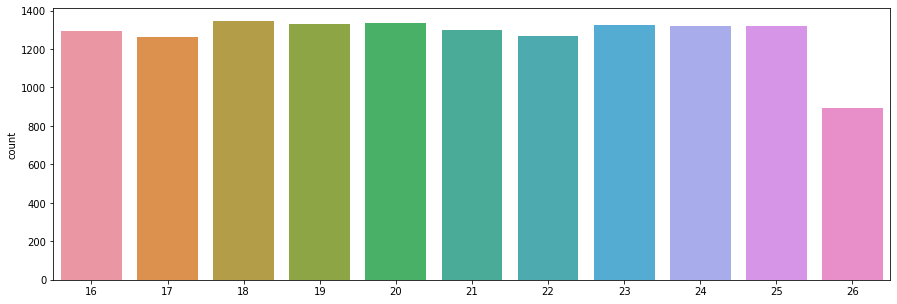

In [ ]:
plt.figure(figsize = (15,5))
sns.countplot(y_train)
plt.show()

<p align='justify'>
Dal grafico si evidenzia come le classi in generale siano <i>bilanciate</i>, <i>eccezion fatta per la classe 26</i>, che riporta la lettera z, di cui abbiamo meno esempi nel traning set. In prima istanza provo a mantenere tutto così com'è avendo comunque molti esempi per ogni classe.
</p>

### Y label
Verifico i valori assunti dalle label. 

In [ ]:
print("Le label assumono i seguenti valori:", set(y_train))

# get the total number of labels
n_labels = len(set(y_train))

Le label assumono i seguenti valori: {16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}


<p align='justify'>
Dato che le label assumono valori nel range $[16,26]$ sarà necessario convertirle nel range $[0,11]$, inoltre per il modello può essere utile ottenere una codifica in 1-hot encoding.
<p>

## Preprocessing
<p align='justify'>
In questa sezione mi occuperò di gestire le problematiche evidenziate dall'analisi del dataset in modo da ottenere un ''nuovo'' dataset pronto per essere passato al modello neurale. In particolare si effettuaranno i seguenti preprocessing:


1.   Conversione dei valori in float e nell'intervallo $[0,1]$
2.   Modifica della shape del dataset da tre a due dimensioni. In questo modo ogni immagine sarà rappresentata da un unica riga contenente $784$ valori.
3.   Conversione delle label nel range $[0,11]$ e applicazione 1-hot encoding.

Inoltre si procederà a splittare il dataset di training per ottenere una piccola porzione di validation utile per valutare i modelli creati.

</p>

In [ ]:
def preprocessing_train(train_data):
  # function to apply the two preprocessing phase to a dataset. 
  # In this way I can use the same function for the test set.

  # converting to float values and to [0,1] range
  train_data = train_data.astype('float32')/255.0

  # Reshaping
  train_data = train_data.reshape((len(train_data), np.prod(train_data.shape[1:])))

  return train_data

In [ ]:
# apply preprocessing
x_train = preprocessing_train(x_train)

# check new shape and new max/min values
print("Valori compresi tra [" + str(x_train[0].min()) + "," +
      str(x_train[0].max())  + "]")

print("Training set shape" + str(x_train.shape))

Valori compresi tra [0.0,1.0]
Training set shape(14000, 784)


In [ ]:
# get 1-hot encoding labels
yc_train = to_categorical(y_train-16, n_labels)

In [ ]:
# splitting training data to get a test set with label for check model score
x_train2, x_test2, y_train2, y_test2 = train_test_split(x_train, yc_train, 
                                                        test_size = 0.1,
                                                        random_state=99)

### More consideration about test set 2
<p align="justify">
Si è deciso di implementare sia un test set sia un validation set questo per diversi motivi. 
In primo luogo il <b>validation set</b> sarà utilizzato per <i>stoppare il traning del modello</i> prevendo eventuali overfitting grazie alla tecnica di early_stopping. Tuttavia questo validation set è estratto dai dati di traning che sono stati ribilanciati e quindi <i>"lontani" dal mondo reale</i> e quindi non sarebbe ideale per la valutazione delle metriche del modello, in tal senso viene utilizzato il <b>test set</b> che è invece stato estratto prima del ribilanciamento e quindi <i>mantiene lo sbilanciamento</i> sulla classe `DEFAULT` come ci si aspetta che avvenga anche nel <i>mondo reale</i> e quindi con dati mai visti.

## Supervised classification with a traditional neural network
<p align='justify'>
In questa sezione provo a trattare il problema di classificazione attraverso l'uso di modelli di deep learning standard, come FFNN. <br>
In particolare verranno riportati due modelli che adottano due tecniche di regolarizzazione diverse (L2 vs dropout) in modo da poterli confrontare. 
Si segnala che i modelli riportati sono quelli risultati i migliori dopo diverse prove effettuate con varie combinazioni di layer/funzioni di attivazione/tecniche di regolarizzazione. <br>
In questa prima sezione vengono riportate due funzioni utili per valutare i modelli, una prima che permette di visualizzare la storia del training, ed una seconda che permette di calcolare le perfomance sul modello.
</p>

In [ ]:
# Function for easily  plotting neural network training history
def plot_history(network_history):
    plt.figure(figsize = (13, 6))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('model loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure(figsize = (13, 6))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('model accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

In [ ]:
def evaluate_predition_ffnn(model, df_X, df_Y):
  # function to evaluate and display metrics
  
  # predict y label
  y_hat = model.predict(df_X)
  # get the top score
  y_hat = y_hat.argmax(axis=1)


  # get top score for real y label
  df_Y = df_Y.argmax(axis = 1)

  df_Y = df_Y+16 
  y_hat = y_hat+16 
  # compute confusion matrix
  cm = confusion_matrix(df_Y, y_hat)

  cl = classification_report(df_Y, y_hat, output_dict=True) 
  print('\nClassification Report\n', classification_report(df_Y, y_hat))

  # plot beautiful confusion matrix
  ax = plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', cmap="YlGnBu");  

  ax.set_xlabel('True labels'); ax.set_ylabel('Predicted labels'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(['P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']); 
  ax.yaxis.set_ticklabels(['P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']);

  return y_hat, cl


### FFNN with L2 regularization
<p align='justify'>
Si riporta come primo esempio un modello addestrato con la tecnica di regolarizzazione L2. Applico inoltre il metodo dell'early stopping che permette di fermare l'apprendimento del modello qualora non vi fossero dei miglioramenti in 3 epoche consecutive, l'implementazione dell'early stopping inoltre riporta la rete all'epoca migliore trovata fino a quel momento.
</p>

In [ ]:
# Sequential model
model_l2 = keras.Sequential()

# setting the input layer (not necessarly but good for report)
model_l2.add(keras.Input(x_train2.shape[1:]))

# 2xFC @ 128, non linear
model_l2.add(keras.layers.Dense(128, activation='relu', 
                             kernel_regularizer=regularizers.l2(0.01)))

# output layer for predicting class
model_l2.add(keras.layers.Dense(n_labels, activation='softmax'))

# optimization
model_l2.compile(optimizer = "sgd", loss = "categorical_crossentropy", 
              metrics = ["accuracy"])

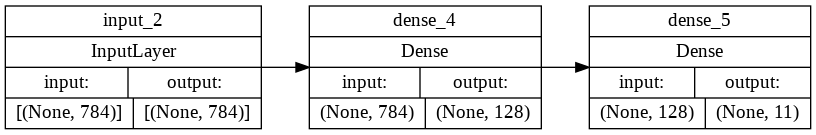

In [ ]:
# visualizing model
plot_model(model_l2, show_shapes=True, rankdir="LR")

In [ ]:
# adding early stopping, in this way I don't have to check number of epochs
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=2, 
                               min_delta = 0.001, mode='min', 
                               restore_best_weights=True)

# fitting the model with l1 regularization
# add a shuffle because I haven't reshuffle data after splitting
# keep the validation split for check results and when to stop with earlystopping method
history_l2 = model_l2.fit(x_train2, y_train2, epochs = 300, batch_size = 128, 
                          verbose = 2, shuffle = True, validation_split=0.1,
                          callbacks=[early_stopping])

Epoch 1/300
89/89 - 1s - loss: 4.2870 - accuracy: 0.3294 - val_loss: 3.9630 - val_accuracy: 0.4937 - 917ms/epoch - 10ms/step
Epoch 2/300
89/89 - 0s - loss: 3.6981 - accuracy: 0.5924 - val_loss: 3.4941 - val_accuracy: 0.6333 - 362ms/epoch - 4ms/step
Epoch 3/300
89/89 - 0s - loss: 3.3171 - accuracy: 0.6745 - val_loss: 3.1976 - val_accuracy: 0.6841 - 319ms/epoch - 4ms/step
Epoch 4/300
89/89 - 0s - loss: 3.0767 - accuracy: 0.7053 - val_loss: 3.0073 - val_accuracy: 0.7000 - 312ms/epoch - 4ms/step
Epoch 5/300
89/89 - 0s - loss: 2.9109 - accuracy: 0.7247 - val_loss: 2.8645 - val_accuracy: 0.7079 - 319ms/epoch - 4ms/step
Epoch 6/300
89/89 - 0s - loss: 2.7828 - accuracy: 0.7366 - val_loss: 2.7495 - val_accuracy: 0.7254 - 297ms/epoch - 3ms/step
Epoch 7/300
89/89 - 0s - loss: 2.6755 - accuracy: 0.7466 - val_loss: 2.6527 - val_accuracy: 0.7310 - 302ms/epoch - 3ms/step
Epoch 8/300
89/89 - 0s - loss: 2.5818 - accuracy: 0.7555 - val_loss: 2.5646 - val_accuracy: 0.7405 - 316ms/epoch - 4ms/step
Epoch 9

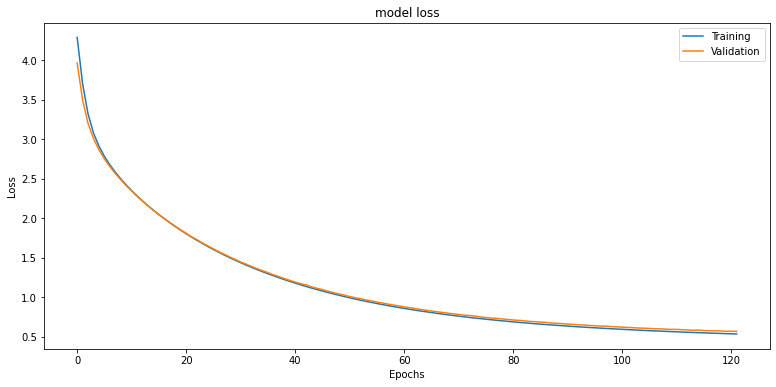

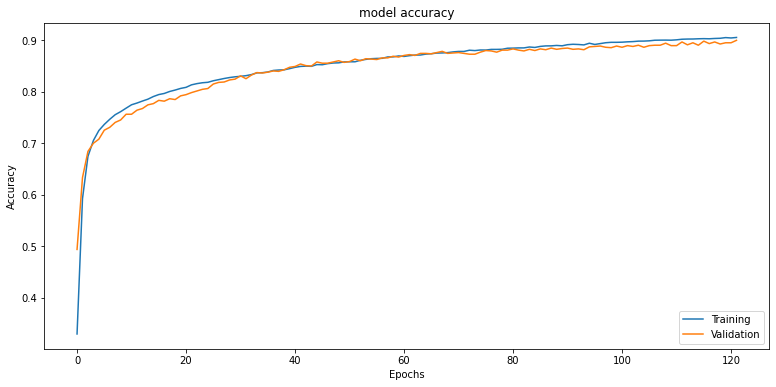

In [ ]:
plot_history(history_l2)

<p align='justify'>
Il modello sembra essere ottimale rispetto alle possibili problematiche di under/overfitting se ci riferiamo alla loss. Per quanto riguarda l'accuracy si possono invece notare dei piccoli cambiamenti in positivo e negativo durante tutto il tranining, nonostante ciò l'andamento generico tra training set e validation set è moldo simile. Tuttavia questo modello richiede <i> un numero abbastanza alto di epoche </i> durante la fase di training.
</p>

#### L2 results
Verifico i risultati ottenuti con L2 in termini di performance del modello utilizzando il test set appositamente estratto in precedenza.


Classification Report
               precision    recall  f1-score   support

          16       0.92      0.91      0.91       129
          17       0.82      0.85      0.83       117
          18       0.82      0.82      0.82       124
          19       0.96      0.94      0.95       134
          20       0.89      0.86      0.87       132
          21       0.85      0.87      0.86       128
          22       0.89      0.87      0.88       145
          23       0.86      0.93      0.89       125
          24       0.88      0.88      0.88       137
          25       0.84      0.84      0.84       140
          26       0.92      0.90      0.91        89

    accuracy                           0.88      1400
   macro avg       0.88      0.88      0.88      1400
weighted avg       0.88      0.88      0.88      1400



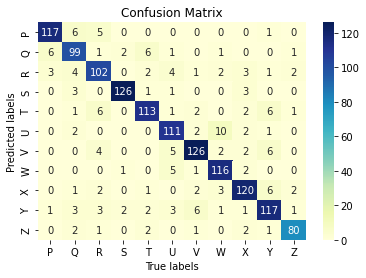

In [ ]:
y_hat_l2, cl_l2 = evaluate_predition_ffnn(model_l2, x_test2, y_test2)

<p align='justify'>
I risultati ottenuti sembrano abbastanza buoni, anche se l'accuracy si ferma a $0.88$. In particolare si segnala la problematica della $W$ che viene spesso interpretata come un $V$. <br>
Durante l'implementazione ho provato anche ad aggiungere altri layer, invece che uno solo da 128, ma le performance non aumentavano in modo significativo. Per questo motivo ho deciso di mantenere il modello più semplice tra quelli testati con regolarizzazione L2.
</p>

### FFNN with dropout regularization
<p align='justify'>
Invece di applicare la regolarizzazione L2, come nel caso precedente, provo ad introdurre dei layer di dropout per vedere se riesco a migliorare le performance del modello. <br>
Anche in questo caso la configurazione del modello proposta è stata raggiunta dopo diversi tentativi, inoltre si utilizza lo stesso early stopping definito in precedenza per fermare il training del modello se necessario. Tra le varie opzioni egualmente valide ho scelto quella più generica e con meno neuroni richiesti per l'implementazione.
</p>

In [ ]:
model_do = Sequential()

# 2xFC @ 256, non linear
model_do.add(Dense(256, activation = "relu", input_shape=(x_train2.shape[1:])))
model_do.add(Dense(256, activation = "relu"))
model_do.add(Dropout(0.5)) # dropout
# FC @ 64, non linear
model_do.add(Dense(64, activation = "relu"))
model_do.add(Dropout(0.55)) # dropout
# FC @ 16, non linear (no dropout)
model_do.add(Dense(16, activation = "relu"))

# final layer
model_do.add(Dense(n_labels, activation="softmax"))

# optimization
model_do.compile(optimizer = "adam", loss = "categorical_crossentropy", 
              metrics = ["accuracy"])

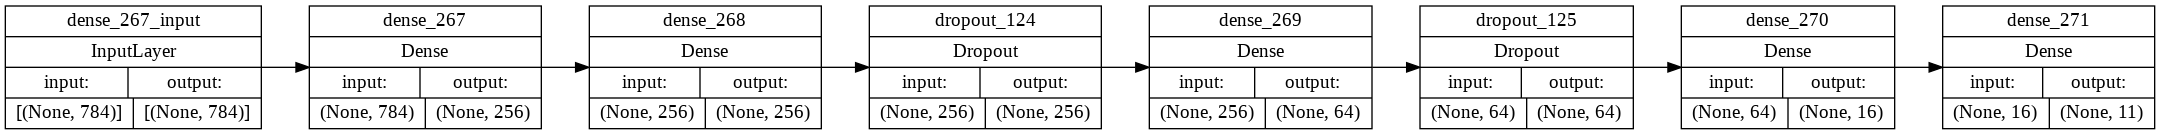

In [ ]:
# visualizing model
plot_model(model_do, show_shapes=True, rankdir="LR")

In [ ]:
# fitting the model with dropout regularization
# add a shuffle because I haven't reshuffle data after splitting
# keep the validation split for check results and when to stop with earlystopping method
history_do = model_do.fit(x_train2, y_train2, epochs = 300, batch_size = 64, 
                          verbose = 2, shuffle = True, validation_split=0.1,
                          callbacks=[early_stopping])

Epoch 1/300
178/178 - 2s - loss: 1.5328 - accuracy: 0.4811 - val_loss: 0.7138 - val_accuracy: 0.7857 - 2s/epoch - 9ms/step
Epoch 2/300
178/178 - 1s - loss: 0.7562 - accuracy: 0.7705 - val_loss: 0.3739 - val_accuracy: 0.8913 - 748ms/epoch - 4ms/step
Epoch 3/300
178/178 - 1s - loss: 0.5098 - accuracy: 0.8526 - val_loss: 0.3062 - val_accuracy: 0.9111 - 729ms/epoch - 4ms/step
Epoch 4/300
178/178 - 1s - loss: 0.4034 - accuracy: 0.8867 - val_loss: 0.2626 - val_accuracy: 0.9246 - 801ms/epoch - 4ms/step
Epoch 5/300
178/178 - 1s - loss: 0.3349 - accuracy: 0.9083 - val_loss: 0.2501 - val_accuracy: 0.9302 - 755ms/epoch - 4ms/step
Epoch 6/300
178/178 - 1s - loss: 0.2782 - accuracy: 0.9213 - val_loss: 0.2365 - val_accuracy: 0.9310 - 767ms/epoch - 4ms/step
Epoch 7/300
178/178 - 1s - loss: 0.2366 - accuracy: 0.9340 - val_loss: 0.2300 - val_accuracy: 0.9373 - 764ms/epoch - 4ms/step
Epoch 8/300
178/178 - 1s - loss: 0.2062 - accuracy: 0.9421 - val_loss: 0.2120 - val_accuracy: 0.9468 - 757ms/epoch - 4ms/

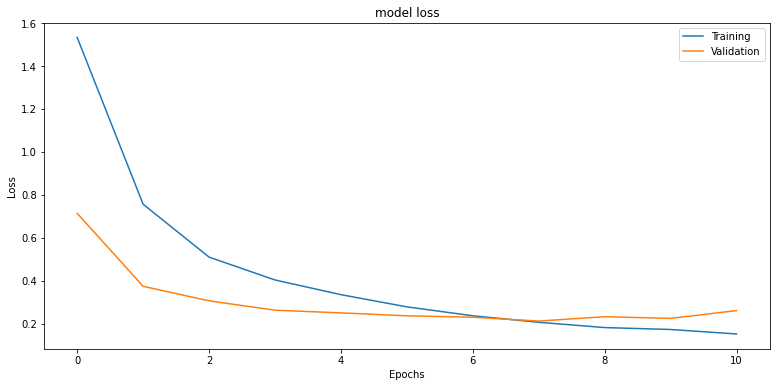

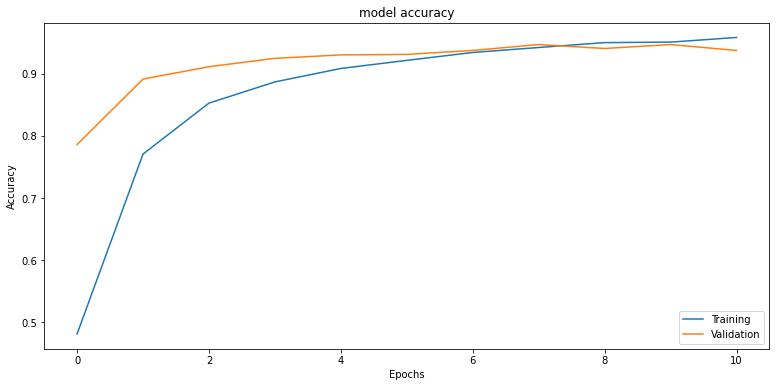

In [ ]:
plot_history(history_do)

<p align='justify'>
In questo caso il modello segue l'andamento della training loss, anche se nelle prime epoche diverge abbastanza. Tuttavia poi l'andamento risulta essere molto simile e non segnala particolari problemi di underfitting come farebbero pensare le prime due epoche. <br>
Si segnala inoltre che l'early stopping riporta i pesi all'iterazione migliore e non utilizza gli ultimi, questo esclude quindi i pesi delle ultime due epoche che sembrano portare il modello all'overfitting
</p>

#### Dropout results
Verifico i risultati ottenuti con dropout in termini di performance del modello utilizzando il test set appositamente estratto in precedenza.


Classification Report
               precision    recall  f1-score   support

          16       0.93      0.94      0.93       129
          17       0.87      0.92      0.90       117
          18       0.96      0.90      0.93       124
          19       0.97      0.96      0.97       134
          20       0.97      0.96      0.97       132
          21       0.90      0.92      0.91       128
          22       0.94      0.94      0.94       145
          23       0.93      0.96      0.94       125
          24       0.95      0.93      0.94       137
          25       0.95      0.89      0.92       140
          26       0.92      0.97      0.95        89

    accuracy                           0.94      1400
   macro avg       0.94      0.94      0.94      1400
weighted avg       0.94      0.94      0.94      1400



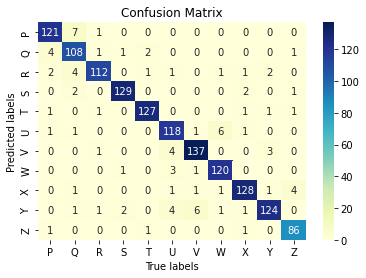

In [ ]:
y_hat_do, cl_do = evaluate_predition_ffnn(model_do, x_test2, y_test2)

<p align='justify'>
Questo modello evidenzia un forte miglioramento dell'accuracy che arriva a circa $0.94$ a livello di <b>macro avg</b>! Ho scelto di considerare maggiormente come metrica la macro avg, invece dell'accuracy, perchè è una media dell'f1-score ottenuto sulle singole label. <br>
Il modello con dropout risulta quindi essere meglio rispetto al modello con regolarizzazione L2, sia a livello di accuracy ma anche perchè richiede molte meno epoche per essere trainato.
</p>

In [ ]:
print("numero di epoche con regolarizzazione l2:", len(history_l2.epoch))
print("numero di epoche con dropout:", len(history_do.epoch))
print("Macro avg (f1-score) finale con regolarizzazione l2:",cl_l2['macro avg']['f1-score'])
print("Macro avg (f1-score) con dropout:",cl_do['macro avg']['f1-score'])

numero di epoche con regolarizzazione l2: 134
numero di epoche con dropout: 11
Macro avg (f1-score) finale con regolarizzazione l2: 0.8793298260599675
Macro avg (f1-score)  con dropout: 0.9355618910784519


### Make predictions
<p align='justify'>
Utilizzo il modello con regolarizzazione dropout per calcolare le previsioni sul test set caricato nella sezione "Loading Data" e esporto il risultato. Per poter effettuare la predizione su questo test set per prima cosa applico lo stesso preprocessing applicato al traninig set. <br>
Le perfomance su questo test set mi aspetto che siano molto simili a quelle ottenute dal validation set e quelle commentate nella sezione results del dropout, in cui sono state calcolate le predizioni su un test set aggiuntivo appositamente estratto dai dati di training.
</p>

In [ ]:
# apply preprocessing phase
x_test = preprocessing_train(x_test)

In [ ]:
# get prediction for test set
yhat_test = model_do.predict(x_test)
# get the top score
yhat_test = yhat_test.argmax(axis=1)

# reconvert score from [0,10] to [16,26]
yhat_test = yhat_test + 16

#### OPTIONAL - exporting prediction

In [ ]:
# write prediction to .txt file
with open("Riccardo_Confalonieri_830404_score2.txt", 'w') as f:
    for item in yhat_test:
        f.write(str(item)+",\n")

## Auto-encoder model
<p align='justify'>
Sfruttando gli stessi dati utilizzati finora creo un modello autoencoder. In particolare valuterò prima visivamente l'encoding e poi applico un modello si classificazione di tipo supervisionato a partire proprio dall'encoder sviluppato.
</p>

In [ ]:
# size of encoded representations
encoding_dim = 64  # 64 floats -> compression of factor 12.25

# define input layer
input_img = Input(shape=x_train2.shape[1:])
# first layer for encode the input (784 -> 128)
encoded = Dense(128, activation='relu')(input_img)
# second layer for encode the input (784 -> 32)
encoded = Dense(encoding_dim, activation='relu')(encoded)

# "decoded" is the lossy reconstruction of the input (32 -> 128)
decoded = Dense(128, activation='relu')(encoded)
# second decoding layer (128 -> 784)
decoded = Dense(784, activation='sigmoid')(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# optimization function. With mse I'm done a regression for each pixel values
autoencoder.compile(optimizer="adam", loss='binary_crossentropy', 
                    metrics = ["mse"])

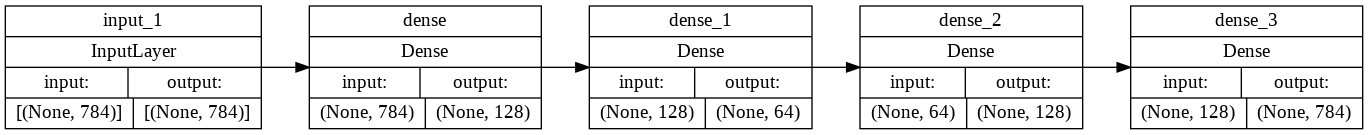

In [ ]:
# visualizing model
plot_model(autoencoder, show_shapes=True, rankdir="LR")

In [ ]:
# encoding the x_train
history_autoen = autoencoder.fit(x_train2,x_train2, epochs=300, batch_size=256,
                                 shuffle=True, validation_split=0.1)

Epoch 1/300
45/45 [==============================] - 4s 10ms/step - loss: 0.4364 - mse: 0.1116 - val_loss: 0.3407 - val_mse: 0.0787
Epoch 2/300
45/45 [==============================] - 0s 6ms/step - loss: 0.3070 - mse: 0.0664 - val_loss: 0.2775 - val_mse: 0.0562
Epoch 3/300
45/45 [==============================] - 0s 7ms/step - loss: 0.2555 - mse: 0.0484 - val_loss: 0.2349 - val_mse: 0.0416
Epoch 4/300
45/45 [==============================] - 0s 6ms/step - loss: 0.2207 - mse: 0.0367 - val_loss: 0.2098 - val_mse: 0.0333
Epoch 5/300
45/45 [==============================] - 0s 6ms/step - loss: 0.2011 - mse: 0.0303 - val_loss: 0.1945 - val_mse: 0.0283
Epoch 6/300
45/45 [==============================] - 0s 6ms/step - loss: 0.1881 - mse: 0.0260 - val_loss: 0.1841 - val_mse: 0.0249
Epoch 7/300
45/45 [==============================] - 0s 6ms/step - loss: 0.1794 - mse: 0.0233 - val_loss: 0.1782 - val_mse: 0.0232
Epoch 8/300
45/45 [==============================] - 0s 6ms/step - loss: 0.1738 - 

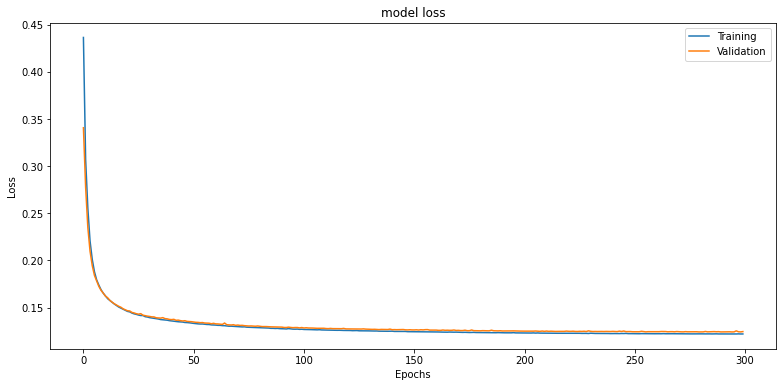

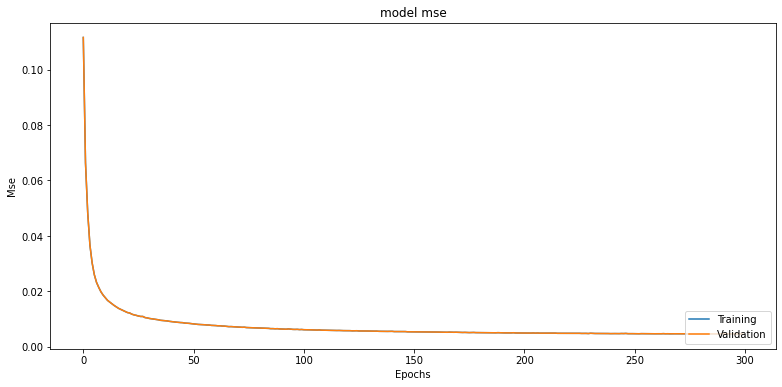

In [ ]:
plt.figure(figsize = (13, 6))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('model loss')
plt.plot(history_autoen.history['loss'])
plt.plot(history_autoen.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure(figsize = (13, 6))
plt.xlabel('Epochs')
plt.ylabel('Mse')
plt.title('model mse')
plt.plot(history_autoen.history['mse'])
plt.plot(history_autoen.history['mse'])
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

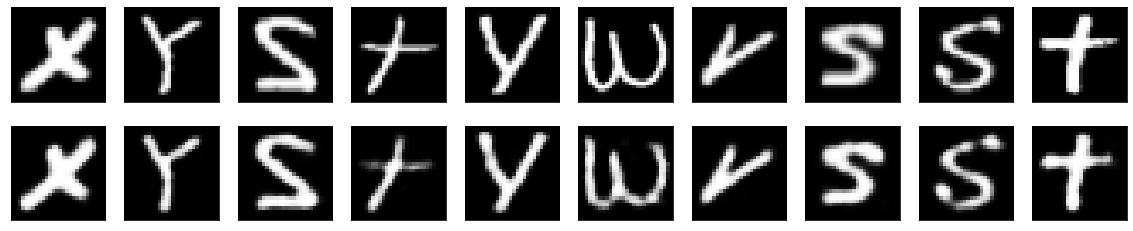

In [ ]:
# encode + decond all images of x_test2
x_selected = x_test2
decoded_imgs = autoencoder.predict(x_selected)

# visualize the first 10 decoded image
n = 10 
plt.figure(figsize=(20, 4))
for i in range(n):
    # original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_selected[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    # remove axis from visualization
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

<p align='justify'>
Le immagini risultano essere molto simili ma non uguali. Ad esempio nella lettera $t$ (quarta colonna) si nota chiaramente la differenza che viene applicata dall'autoencoder.
</p>

#### OPTIONAL - Classification with autoencoder
<p align = 'justify'>
Uso le immagini generate con l'autoencoder per risolvere il task di classificazione delle immagini nella classe di appartenenza $[16, 26]$. Per risolvere questo task in primi estraggo dall'autoencoder la parte di encoding. 
Successivamente utilizzerò questa nuova visualizzazione delle immagini in un modello FFNN per predire la classe di appartenenza. (Potevo usare anche SVM come suggerito, ma per semplicità e prosecuzione del notebook ho usato nuovamente le reti neurali).
</p>

In [ ]:
# get the first part of the model (input to encoded representation)
encoder = Model(input_img, encoded)

New image dimension: 64


<p align = 'justify'> 
Le immagini che si ottengono applicando l'encoder sono di dimensione $64$ per come è stato definito l'autoencoder. A partire da questa immagina applico un semplice modello di FFNN per predire la classe.
</p>

In [ ]:
model_en = Sequential()

# FC @ 64, non linear
model_en.add(Dense(64, activation = "relu", input_shape=(encoded_imgs.shape[1:])))

# FC @ 16, non linear (no dropout)
model_en.add(Dense(16, activation = "relu"))

# final layer
model_en.add(Dense(n_labels, activation="softmax"))

# optimization
model_en.compile(optimizer = "adam", loss = "categorical_crossentropy", 
              metrics = ["accuracy"])

In [ ]:
# fitting the model
# add a shuffle because I haven't reshuffle data after splitting
# keep the validation split for check results and when to stop with earlystopping method
history_en = model_en.fit(encoded_imgs, y_train2, epochs = 100, batch_size = 128, 
                          verbose = 1, shuffle = True, validation_split=0.1,
                          callbacks=[early_stopping])

Epoch 1/100
89/89 [==============================] - 1s 7ms/step - loss: 0.5032 - accuracy: 0.8444 - val_loss: 0.2902 - val_accuracy: 0.9095
Epoch 2/100
89/89 [==============================] - 0s 5ms/step - loss: 0.1261 - accuracy: 0.9608 - val_loss: 0.2617 - val_accuracy: 0.9254
Epoch 3/100
89/89 [==============================] - 0s 5ms/step - loss: 0.0718 - accuracy: 0.9761 - val_loss: 0.3200 - val_accuracy: 0.9079
Epoch 4/100
89/89 [==============================] - 0s 5ms/step - loss: 0.0579 - accuracy: 0.9820 - val_loss: 0.2968 - val_accuracy: 0.9222
Epoch 00004: early stopping



Classification Report
               precision    recall  f1-score   support

          16       0.92      0.94      0.93       129
          17       0.91      0.86      0.89       117
          18       0.93      0.82      0.87       124
          19       0.96      0.96      0.96       134
          20       0.94      0.92      0.93       132
          21       0.89      0.86      0.88       128
          22       0.89      0.91      0.90       145
          23       0.91      0.96      0.93       125
          24       0.88      0.95      0.92       137
          25       0.91      0.85      0.88       140
          26       0.85      0.97      0.91        89

    accuracy                           0.91      1400
   macro avg       0.91      0.91      0.91      1400
weighted avg       0.91      0.91      0.91      1400



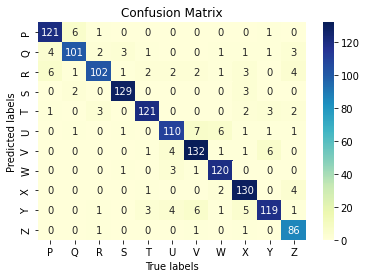

In [ ]:
# encoding the test set
encoded_test = encoder.predict(x_test2)

y_hat_en, cl_en = evaluate_predition_ffnn(model_en, encoded_test, y_test2)

<p align = 'justify'>
Il modello FFNN applicato dopo l'autoencoder risulta migliore rispetto a quello con la regolarizzazione L2 ma comunque peggiore rispetto al dropout.
</p>

## Future improvement
<p align='justify'>
In questo notebook non è stata considerata come tecnica di regolarizzazione la data augmentation. Si potrebbe infatti provare ad applicare questa tecnica, dato che però i dati sono immagini in questo caso non tutte le tecniche sono applicabili (es: non posso ruotare le immagini o ribaltarle). Si potrebbe provare a ``stirare" l'immagine, per ottenere più immagini di training comunque valide.
</p>

In [ ]:
# download notebook in .html extension
%%shell
jupyter nbconvert --to html '/content/drive/MyDrive/Colab Notebooks/AML/Assignment/Assignment2/Assignment2.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/AML/Assignment/Assignment2/Assignment2.ipynb to html
[NbConvertApp] Writing 765702 bytes to /content/drive/MyDrive/Colab Notebooks/AML/Assignment/Assignment2/Assignment2.html
